the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1022/2440353648.py:71: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


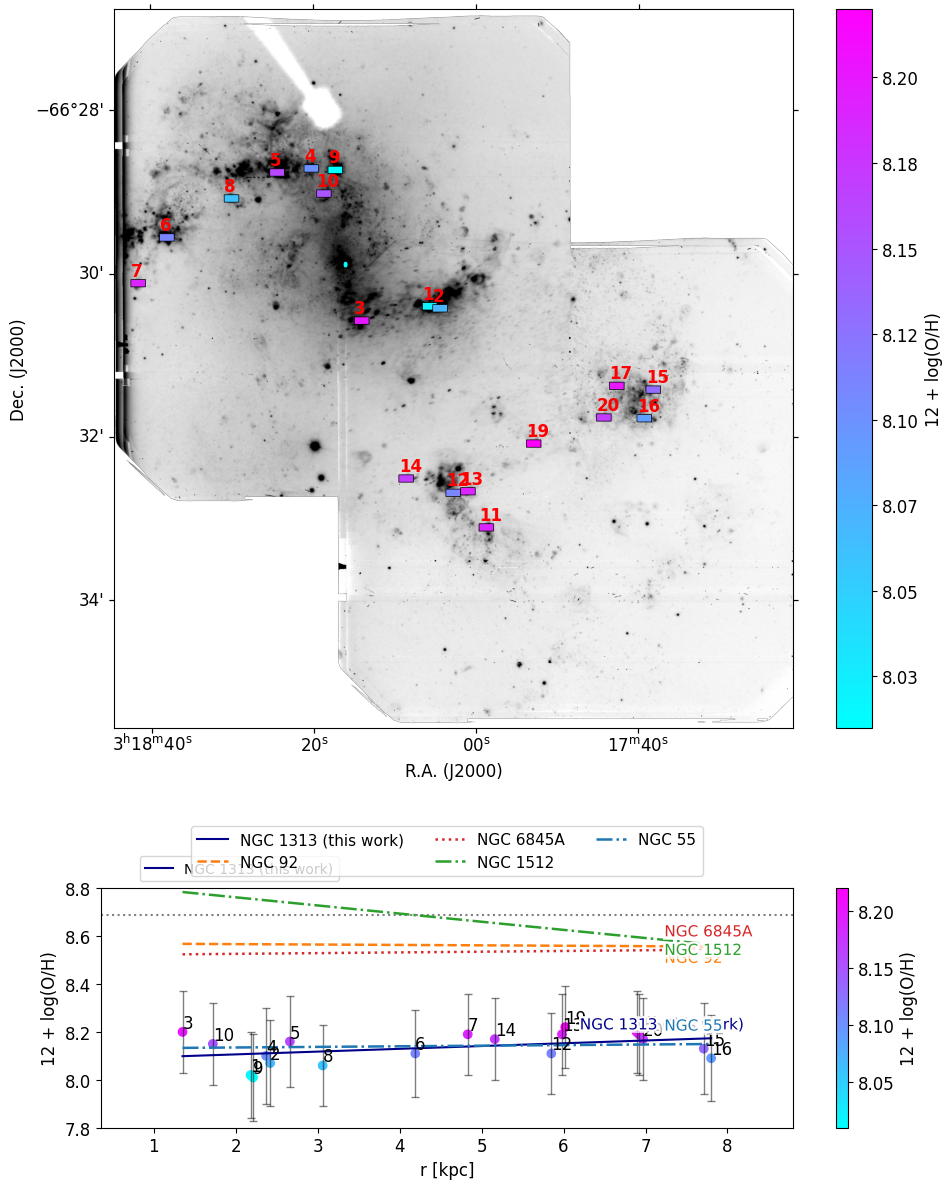

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs
from matplotlib.ticker import FormatStrFormatter


# Parámetro para las colorbars
color_param = '12_LOG_OH_N2'

param_labels = {
    'mass': r'$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': r'12 + log(O/H)',
    'age': r'Age [$\times10^6$ yr]',
    'n_e': r'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('analysis_gmos/gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('analysis_gmos/output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0003

# Cargar imágenes FITS
hdul1 = fits.open('../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)
ax1.tick_params(labelsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=12, transform=ax1.get_transform('world'),
        va='bottom', fontweight='bold', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1, format='%.2f')
cbar1.set_label(param_labels[color_param], fontsize=12)
cbar1.ax.tick_params(labelsize=12)


# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=12, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue',
                 label='NGC 1313 (this work)')  # <— leyenda limpia




# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=12)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.tick_params(labelsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2, format='%.2f')
cbar2.set_label(param_labels[color_param], fontsize=12)
cbar2.ax.tick_params(labelsize=12)

# === COMPARADORES: líneas de la literatura (con labels) ===
x0, x1 = np.min(x), np.max(x)

tf_color = 'tab:orange'
or_color = 'tab:red'
br_color = 'tab:green'
mg_color = 'tab:blue'

# NGC 92 — Torres-Flores+2014: m=-0.0017, b=8.57
tf_line, = ax2.plot([x0, x1],
                    [(-0.0017)*x0 + 8.57, (-0.0017)*x1 + 8.57],
                    linestyle='--', linewidth=1.8, color=tf_color,
                    label='NGC 92')

# NGC 6845A tail A–B — Olave-Rojas+2015: m=+0.0030, b=8.52
or_line, = ax2.plot([x0, x1],
                    [( 0.0030)*x0 + 8.52, ( 0.0030)*x1 + 8.52],
                    linestyle=':', linewidth=1.8, color=or_color,
                    label='NGC 6845A')

# NGC 1512 — Bresolin+2012 (N2): m=-0.0340, b=8.83
br_line, = ax2.plot([x0, x1],
                    [(-0.0340)*x0 + 8.83, (-0.0340)*x1 + 8.83],
                    linestyle='-.', linewidth=1.8, color=br_color,
                    label='NGC 1512')

# NGC 55 — Magrini+2017: m=+0.0025, b=8.13
mg_line, = ax2.plot([x0, x1],
                    [( 0.0025)*x0 + 8.13, ( 0.0025)*x1 + 8.13],
                    linestyle='dashdot', linewidth=1.8, color=mg_color,
                    label='NGC 55')

# === ETIQUETAS "IN-PLOT" DESPLAZADAS A LA DERECHA ===
import matplotlib.patheffects as pe
def place_label(ax, m_cmp, b_cmp, name, color, frac=0.88, dx=12):
    """Coloca la etiqueta cerca de la recta con un pequeño offset."""
    xl = x0 + frac*(x1 - x0)            # más a la derecha para evitar solapamiento
    yl = m_cmp*xl + b_cmp
    dy = 10 if m_cmp >= 0 else -12      # por encima si la pendiente es positiva
    txt = ax.annotate(name, xy=(xl, yl), xycoords='data',
                      xytext=(dx, dy), textcoords='offset points',
                      color=color, fontsize=11,
                      bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.8))
    txt.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])

# Etiqueta de tu ajuste un poco menos a la derecha para separarla del resto
place_label(ax2, m,        b,     "NGC 1313 (this work)", 'darkblue', frac=0.72, dx=12)
place_label(ax2, -0.0017,  8.57,  "NGC 92",               tf_color)
place_label(ax2,  0.0030,  8.52,  "NGC 6845A",            or_color)
place_label(ax2, -0.0340,  8.83,  "NGC 1512",             br_color)
place_label(ax2,  0.0025,  8.13,  "NGC 55",               mg_color)

# === LEYENDA ÚNICA FUERA DEL GRADIENTE (EVITA SOLAPES) ===
# Asegúrate de NO tener otras llamadas a ax2.legend arriba.
ax2.legend(handles=[line, tf_line, or_line, br_line, mg_line],
           loc='lower center', bbox_to_anchor=(0.5, 1.02),
           ncol=3, fontsize=11, frameon=True)




# Ajustar diseño
plt.tight_layout()
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/1d/sms3rjzs38jbhp0zx04sz91c0000gn/T/ipykernel_1022/4254948855.py:71: RuntimeWarning: Mean of empty slice
  combined = np.nanmean([reproj1, reproj2], axis=0)


[[ 4.03841358e-05 -1.85152018e-04]
 [-1.85152018e-04  1.03397464e-03]]
Pendiente: 0.0116 ± 0.0064
Intercepto:          8.0830
Chi-cuadrado:        1.94
Chi-cuadrado red.:   0.11
Grados de libertad:  17
p-valor del ajuste:  1.000


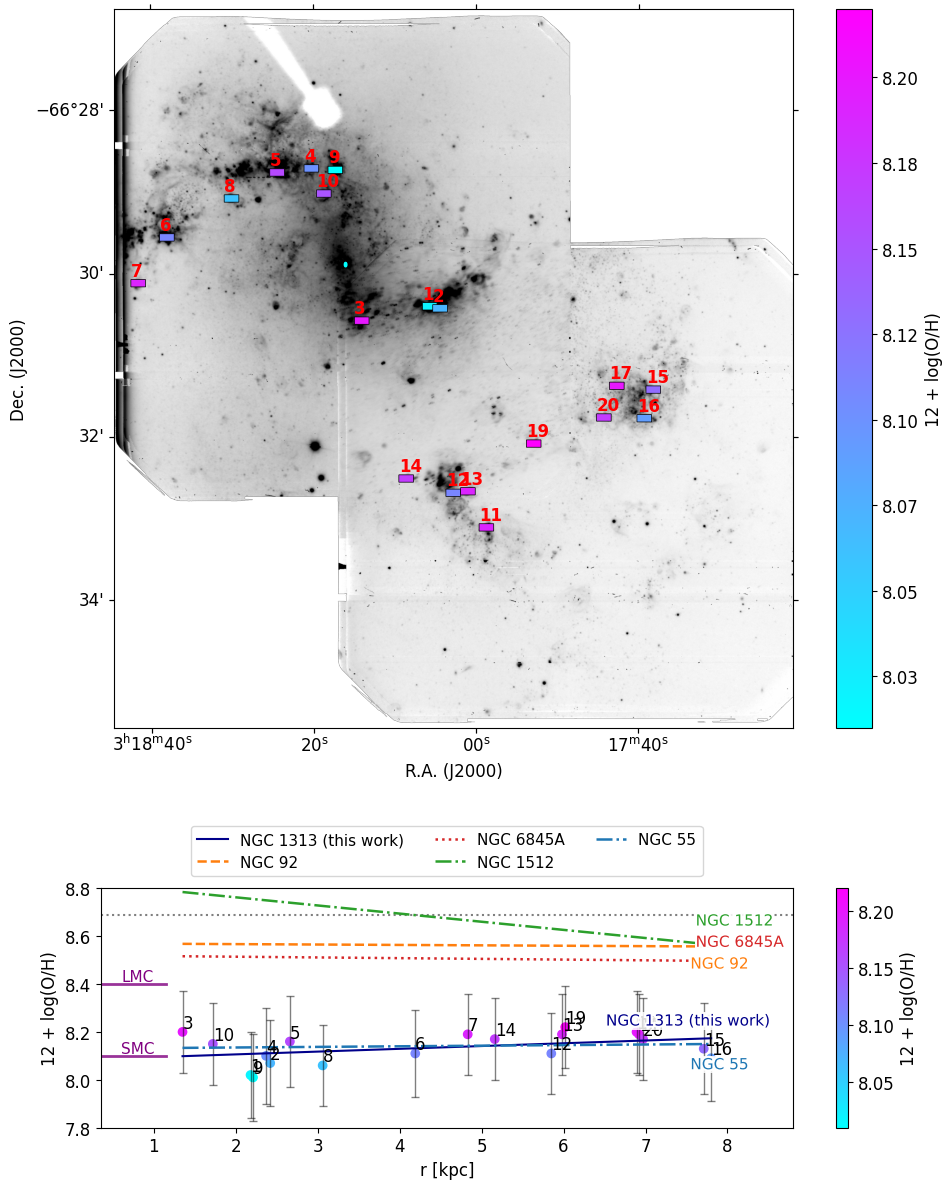

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Rectangle, Circle
from matplotlib.cm import ScalarMappable
from scipy.stats import chi2
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs
from matplotlib.ticker import FormatStrFormatter


# Parámetro para las colorbars
color_param = '12_LOG_OH_N2'

param_labels = {
    'mass': r'$log(M_*)[M_{\odot}]$',
    '12_LOG_OH_N2': r'12 + log(O/H)',
    'age': r'Age [$\times10^6$ yr]',
    'n_e': r'n$_e$ [cm$^{-3}$]'
}

# Cargar datos
df_gradient = pd.read_csv('analysis_gmos/gradiente_scarano_ne_masa_edad_newnumber_ne10.csv', delimiter=',')
df_slits = pd.read_csv('analysis_gmos/output_scarano.csv')
#df_signed = pd.read_csv('signed_distances.csv', delimiter=',')
#df_gradient = pd.merge(df_gradient, df_signed, on='ID')

# Definir grupos
#group_left_galaxy = df_gradient[df_gradient['signed_distance_kpc'] < 0]
#group_right_galaxy = df_gradient[df_gradient['signed_distance_kpc'] >= 0]
#group_clouds = df_gradient[df_gradient['ID'].isin(range(11, 20))]

# Verificar número de puntos en cada grupo
#print(f"Number of points in group_left: {len(group_left_galaxy)}")
#print(f"Number of points in group_right_galaxy: {len(group_right_galaxy)}")
#print(f"Number of points in group_clouds: {len(group_clouds)}")

# Límites para la colorbar
vmin = df_gradient[color_param].min()
vmax = df_gradient[color_param].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.cool

# Parámetros de los slits
width_deg = 0.0075
height_deg = 0.0015
ra_center = 49.566875
dec_center = -66.498250
circle_radius_deg = 0.0003

# Cargar imágenes FITS
hdul1 = fits.open('../../reduccion/mrgS20190730S0157_add.fits')
data1 = hdul1['SCI'].data
wcs1 = WCS(hdul1['SCI'].header)

hdul2 = fits.open('../../reduccion/mrgS20190730S0160_add.fits')
data2 = hdul2['SCI'].data
wcs2 = WCS(hdul2['SCI'].header)

# Enmascarar valores de bordes
data1 = np.where(data1 == 593.67285, np.nan, data1)
data2 = np.where(data2 == 380.0607, np.nan, data2)

# Reproyectar y combinar imágenes
new_wcs, new_shape = find_optimal_celestial_wcs([(data1, wcs1), (data2, wcs2)])
reproj1, _ = reproject_interp((data1, wcs1), new_wcs, shape_out=new_shape)
reproj2, _ = reproject_interp((data2, wcs2), new_wcs, shape_out=new_shape)
combined = np.nanmean([reproj1, reproj2], axis=0)
combined = np.where(combined > 0, combined, np.nan)

# Configurar figura
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])
ax1 = fig.add_subplot(gs[0], projection=new_wcs)
ax2 = fig.add_subplot(gs[1])

# Gráfico superior: imagen de la galaxia
ax1.imshow(combined, origin='lower', cmap='gray_r', norm=LogNorm(vmin=np.nanpercentile(combined, 1), vmax=np.nanpercentile(combined, 99)))
ax1.set_xlabel('R.A. (J2000)', fontsize=12)
ax1.set_ylabel('Dec. (J2000)', fontsize=12)
ax1.tick_params(labelsize=12)

# Añadir slits
for _, row in df_slits.iterrows():
    ra, dec, slit_id = row['RA'], row['DEC'], row['ID']
    param_value = df_gradient[df_gradient['ID'] == slit_id][color_param].values
    if len(param_value) > 0:
        color = cmap(norm(param_value[0]))
    else:
        color = 'gray'
    rect = Rectangle(
        (ra - width_deg/2, dec - height_deg/2),
        width_deg, height_deg,
        edgecolor='black', facecolor=color, lw=0.5,
        transform=ax1.get_transform('world')
    )
    ax1.add_patch(rect)
    ax1.text(
        ra + width_deg/2, dec + height_deg/2, str(int(slit_id)),
        color='red', fontsize=12, transform=ax1.get_transform('world'),
        va='bottom', fontweight='bold', ha='left'
    )

# Añadir círculo azul
circle = Circle(
    (ra_center, dec_center), circle_radius_deg,
    edgecolor='cyan', facecolor='none', lw=2,
    transform=ax1.get_transform('world')
)
ax1.add_patch(circle)
ax1.set_ylim(440, 3740)

# Barra de color para la imagen
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = fig.colorbar(sm, ax=ax1, format='%.2f')
cbar1.set_label(param_labels[color_param], fontsize=12)
cbar1.ax.tick_params(labelsize=12)


# Gráfico inferior: gradiente galactocéntrico
x = df_gradient['r_kpc'].values
y = df_gradient['12_LOG_OH_N2'].values
sigma_y = df_gradient['12_LOG_OH_N2_TOTAL_ERR'].values

# Ajuste lineal ponderado
weights = 1 / sigma_y
coeffs, cov = np.polyfit(x, y, deg=1, w=weights, cov=True)
m, b = coeffs
m_err = np.sqrt(cov[0,0])
b_err = np.sqrt(cov[1,1])
y_pred = m * x + b
chi_squared = np.sum((y - y_pred)**2 / sigma_y**2)
dof = len(x) - 2
reduced_chi_squared = chi_squared / dof if dof > 0 else np.nan
p_value = 1 - chi2.cdf(chi_squared, dof)

# Ajuste lineal ponderado para Galaxia (Derecho)
# if len(group_right_galaxy) > 1:
#     x2 = group_right_galaxy['signed_distance_kpc'].values
#     y2 = group_right_galaxy['12_LOG_OH_N2'].values
#     sigma_y2 = group_right_galaxy['12_LOG_OH_N2_TOTAL_ERR'].values
#     weights2 = 1 / sigma_y2
#     coeffs2, cov2 = np.polyfit(x2, y2, deg=1, w=weights2, cov=True)
#     m2, b2 = coeffs2
#     m2_err = np.sqrt(cov2[0,0])
#     b2_err = np.sqrt(cov2[1,1])
#     y_pred2 = m2 * x2 + b2
#     chi_squared2 = np.sum((y2 - y_pred2)**2 / sigma_y2**2)
#     dof2 = len(x2) - 2
#     reduced_chi_squared2 = chi_squared2 / dof2 if dof2 > 0 else np.nan
# else:
#     m2, b2, reduced_chi_squared2 = np.nan, np.nan, np.nan

# Ajuste lineal ponderado para Nubes
# if len(group_clouds) > 1:
#     x3 = group_clouds['signed_distance_kpc'].values
#     y3 = group_clouds['12_LOG_OH_N2'].values
#     sigma_y3 = group_clouds['12_LOG_OH_N2_ERR'].values
#     weights3 = 1 / sigma_y3**2
#     m3, b3 = np.polyfit(x3, y3, deg=1, w=weights3)
#     y_pred3 = m3 * x3 + b3
#     chi_squared3 = np.sum((y3 - y_pred3)**2 / sigma_y3**2)
#     dof3 = len(x3) - 2
#     reduced_chi_squared3 = chi_squared3 / dof3 if dof3 > 0 else np.nan
# else:
#     m3, b3, reduced_chi_squared3 = np.nan, np.nan, np.nan

# Imprimir estadísticas
print(cov)
# Imprimir resultados
print(f"Pendiente: {m:.4f} ± {m_err:.4f}")
print(f"Intercepto:          {b:.4f}")
print(f"Chi-cuadrado:        {chi_squared:.2f}")
print(f"Chi-cuadrado red.:   {reduced_chi_squared:.2f}")
print(f"Grados de libertad:  {dof}")
print(f"p-valor del ajuste:  {p_value:.3f}")
# print("\nNubes (IDs 11-19):")
# print(f"Pendiente: {m3:.4f}" if not np.isnan(m3) else "Pendiente: N/A")
# print(f"Intercepto: {b3:.4f}" if not np.isnan(b3) else "Intercepto: N/A")
# print(f"Chi-cuadrado red.: {reduced_chi_squared3:.2f}" if not np.isnan(reduced_chi_squared3) else "Chi-cuadrado red.: N/A")

# Barras de error
ax2.errorbar(x, y, yerr=sigma_y, fmt='none', ecolor='black', capsize=3, alpha=0.5, elinewidth=1)

# Scatter con colorbar
sc = ax2.scatter(x, y, c=df_gradient[color_param], cmap=cmap, vmin=vmin, vmax=vmax)

# Etiquetas de ID
for xi, yi, idi in zip(x, y, df_gradient['ID']):
    ax2.text(xi, yi, str(int(idi)), fontsize=12, ha='left', va='bottom')

# Líneas de regresión

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = m * x_fit + b
line, = ax2.plot(x_fit, y_fit, color='darkblue',
                 label='NGC 1313 (this work)')  # <— leyenda limpia




# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     x_fit2 = np.linspace(np.min(x2), np.max(x2), 100)
#     y_fit2 = m2 * x_fit2 + b2
#     line2, = ax2.plot(x_fit2, y_fit2, color='olivedrab', label=f"Galaxy right = {m2:.3f}x + {b2:.2f}")
#     print(f"x_fit2 range: {np.min(x_fit2)} to {np.max(x_fit2)}")
#     print(f"y_fit2 range: {np.min(y_fit2)} to {np.max(y_fit2)}")

# if len(group_clouds) > 1 and not np.isnan(m3):
#     x_fit3 = np.linspace(np.min(x3), np.max(x3), 100)
#     y_fit3 = m3 * x_fit3 + b3
#     line3, = ax2.plot(x_fit3, y_fit3, color='darkred', label=f"Clouds = {m3:.3f}x + {b3:.2f}\n$\chi^2_{{red}}$={reduced_chi_squared3:.2f}")

# Línea vertical en x=0
ax2.axvline(0, linestyle='--', color='gray')
# Línea vertical en y=8.69
ax2.axhline(8.69, linestyle='dotted', color='gray')

# Leyendas

#legend = ax2.legend(handles=[line], loc='lower center', bbox_to_anchor=(0.2, 1.0))   
#ax2.add_artist(legend)
# if len(group_right_galaxy) > 1 and not np.isnan(m2):
#     legend2 = ax2.legend(handles=[line2], loc='lower center', bbox_to_anchor=(0.65, 1.0))
#     ax2.add_artist(legend2)
# if len(group_clouds) > 1 and not np.isnan(m3):
#     legend3 = ax2.legend(handles=[line3], loc='lower center', bbox_to_anchor=(0.85, 1.0))
#     ax2.add_artist(legend3)

ax2.set_xlabel('r [kpc]', fontsize=12)
ax2.set_ylabel('12 + log(O/H)', fontsize=12)
ax2.tick_params(labelsize=12)
ax2.set_xlim(np.min(x) - 1, np.max(x) + 1)
ax2.set_ylim(7.8, 8.8)

# Barra de color para el gradiente
cbar2 = fig.colorbar(sc, ax=ax2, format='%.2f')
cbar2.set_label(param_labels[color_param], fontsize=12)
cbar2.ax.tick_params(labelsize=12)

# === COMPARADORES: líneas de la literatura (con labels) ===
x0, x1 = np.min(x), np.max(x)

tf_color = 'tab:orange'
or_color = 'tab:red'
br_color = 'tab:green'
mg_color = 'tab:blue'

# NGC 92 — Torres-Flores+2014: m=-0.0017, b=8.57
tf_line, = ax2.plot([x0, x1],
                    [(-0.0017)*x0 + 8.57, (-0.0017)*x1 + 8.57],
                    linestyle='dashed', linewidth=1.8, color=tf_color,
                    label='NGC 92')

# NGC 6845A tail A–B — Olave-Rojas+2015: m=+0.0030, b=8.52
or_line, = ax2.plot([x0, x1],
                    [( -0.0030)*x0 + 8.52, ( -0.0030)*x1 + 8.52],
                    linestyle='dotted', linewidth=1.8, color=or_color,
                    label='NGC 6845A')

# NGC 1512 — Bresolin+2012 (N2): m=-0.0340, b=8.83
br_line, = ax2.plot([x0, x1],
                    [(-0.0340)*x0 + 8.83, (-0.0340)*x1 + 8.83],
                    linestyle='dashdot', linewidth=1.8, color=br_color,
                    label='NGC 1512')

# NGC 55 — Magrini+2017: m=+0.0025, b=8.13
mg_line, = ax2.plot([x0, x1],
                    [( 0.0025)*x0 + 8.13, ( 0.0025)*x1 + 8.13],
                    linestyle='-.', linewidth=1.8, color=mg_color,
                    label='NGC 55')

# === ETIQUETAS "IN-PLOT" AJUSTADAS PARA EVITAR SOLAPES ===
import matplotlib.patheffects as pe

def place_label(ax, m_cmp, b_cmp, name, color, frac=0.955, dx=6, dy=0):
    """
    Coloca etiqueta cerca de la recta con offset controlado.
    frac: fracción del rango x (0 izq → 1 der) donde se ancla la etiqueta.
    dx, dy: desplazamientos en puntos (positivo = derecha/arriba).
    """
    xl = x0 + frac * (x1 - x0)
    yl = m_cmp * xl + b_cmp
    txt = ax.annotate(name, xy=(xl, yl), xycoords='data',
                      xytext=(dx, dy), textcoords='offset points',
                      color=color, fontsize=11, clip_on=False, zorder=6,
                      bbox=dict(facecolor='white', alpha=0.85,
                                edgecolor='none', pad=0.8))
    # halo blanco para mayor legibilidad
    txt.set_path_effects([pe.withStroke(linewidth=3, foreground="white")])

# Coloca tu etiqueta algo más centrada para no chocar con las otras
place_label(ax2, m,        b,     "NGC 1313 (this work)", 'darkblue',
            frac=0.78, dx=8, dy=+12)

# NGC 55: pedir explícitamente "debajo" de la línea
place_label(ax2,  0.0025,  8.13,  "NGC 55",               'tab:blue',
            frac=0.945, dx=6, dy=-18)

# NGC 92: también por debajo (evita solape con NGC 1512)
place_label(ax2, -0.0017,  8.57,  "NGC 92",               'tab:orange',
            frac=0.945, dx=6, dy=-16)

# NGC 1512: por encima (línea cae hacia la derecha)
place_label(ax2, -0.0340,  8.83,  "NGC 1512",             'tab:green',
            frac=0.955, dx=6, dy=+12)

# NGC 6845A: por encima (recta casi horizontal)
place_label(ax2,  -0.0030,  8.52,  "NGC 6845A",            'tab:red',
            frac=0.955, dx=6, dy=+10)


# === LEYENDA ÚNICA FUERA DEL GRADIENTE (sin duplicados) ===
ax2.legend(handles=[line, tf_line, or_line, br_line, mg_line],
           loc='lower center', bbox_to_anchor=(0.5, 1.02),
           ncol=3, fontsize=11, frameon=True)


x0, x1 = ax2.get_xlim()
ax2.plot([x0, x0 + 0.8], [8.40, 8.40], color='purple', lw=2, alpha=0.8)
ax2.plot([x0, x0 + 0.8], [8.10, 8.10], color='purple', lw=2, alpha=0.8)
ax2.text(x0 + 0.25, 8.43, 'LMC', color='purple', fontsize=11, va='center', ha='left')
ax2.text(x0 + 0.25, 8.13, 'SMC', color='purple', fontsize=11, va='center', ha='left')


# Ajustar diseño
plt.tight_layout()
plt.show()
